![Image](image.png)

# **Regression Analysis on Apartments Price**
* I Putu Agastya Harta Pratama - 472876
* Chi Phuong Dao - 474064

May 2025


## Imports & Libraries

Before we begin, we need to import both the train and test_df dataset

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import math
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistical modeling and tests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_ind, chi2_contingency

# Scikit-learn - preprocessing
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer

# Scikit-learn - model selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    KFold
)

# Scikit-learn - feature selection
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer

# Scikit-learn - models
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Scikit-learn - metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)

# Scikit-learn - pipeline
from sklearn.pipeline import Pipeline

In [ ]:
train_df = pd.read_csv('appartments_train.csv')
test_df = pd.read_csv('appartments_test.csv')

test_ids = test_df['unit_id'].copy()
train_df.drop(columns=["unit_id"], inplace=True)
test_df.drop(columns=["unit_id"],  inplace=True)

## Exploratory Data Analysis

### Missing Values

<Axes: >

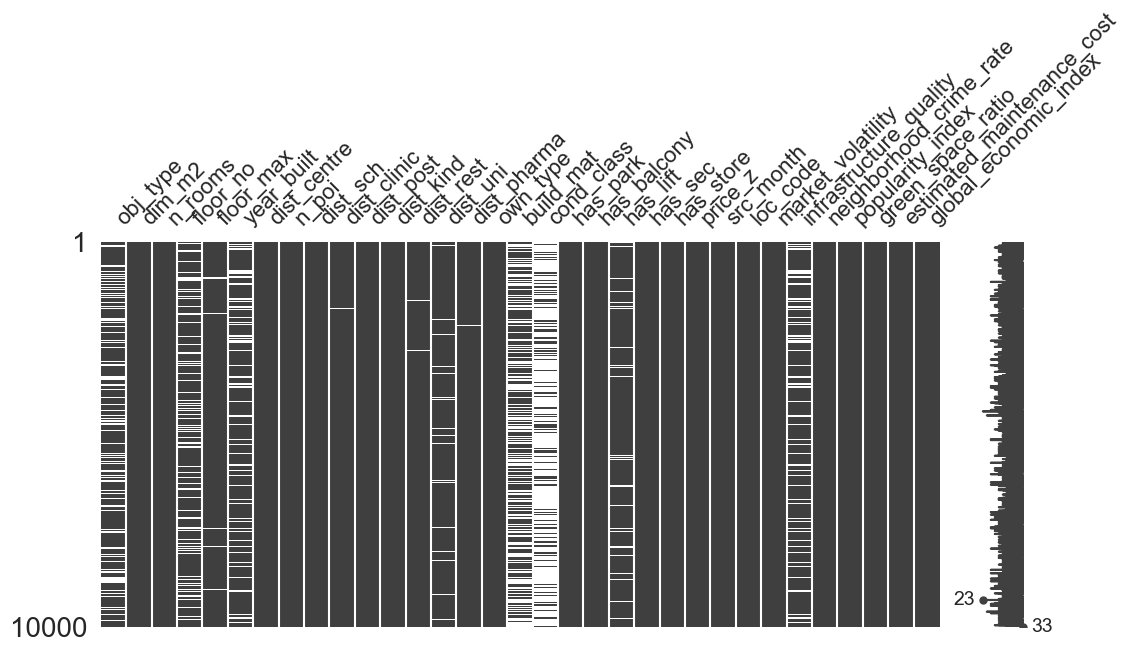

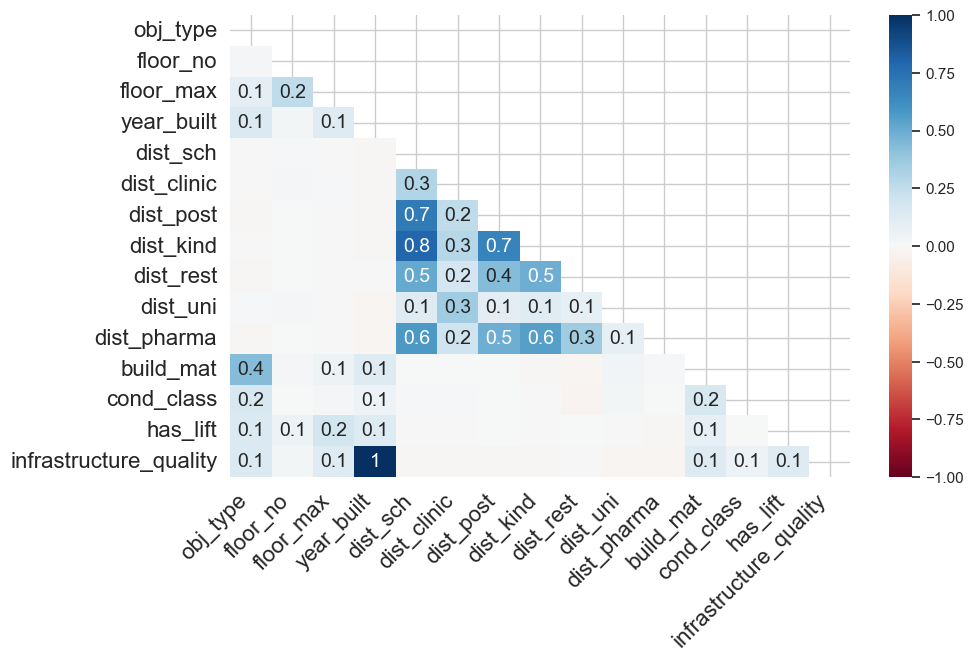

In [ ]:
# Visual missingness map
msno.matrix(train_df.sample(10_000, random_state=42), figsize=(12, 5))

# Co-missingness correlation heatmap
msno.heatmap(train_df.sample(10_000, random_state=42), figsize=(10, 6))

In [ ]:
numerical_cols_missing= train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_na = train_df[numerical_cols_missing].isnull().mean().sort_values(ascending=False) * 100
num_na[num_na >= 0].to_frame("missing_percent")

,missing_percent
floor_no,17.703606
infrastructure_quality,16.434863
year_built,16.434863
dist_uni,2.759277
floor_max,1.227837
dist_clinic,0.364964
dist_rest,0.249914
dist_pharma,0.139977
dist_post,0.120163
dist_kind,0.104184


In [ ]:
categorical_cols_missing = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_na = train_df[categorical_cols_missing].isnull().mean().sort_values(ascending=False) * 100
cat_na[cat_na >= 0].to_frame("missing_percent")

,missing_percent
cond_class,74.819436
build_mat,39.627622
obj_type,21.616577
has_lift,4.938832
own_type,0.000000
has_park,0.000000
has_balcony,0.000000
has_sec,0.000000
has_store,0.000000
src_month,0.000000


A preliminary inspection of missing values reveals substantial gaps in several categorical and numerical variables. Notably, cond_class and build_mat exhibit missing rates exceeding 70% and 39% respectively, raising concerns about their reliability. Among numerical features, floor_no, infrastructure_quality, and year_built show moderate missingness around 16–18%, which may require imputation or exclusion based on further analysis.

Additionally, we're dropping the cond_class variable straight away, as it yields no reasoning to make imputation

In [ ]:
drop_missing_high = ['cond_class']

train_df.drop(columns=drop_missing_high, inplace=True)
test_df.drop(columns=drop_missing_high, inplace=True)

### Univariate Analysis of Target

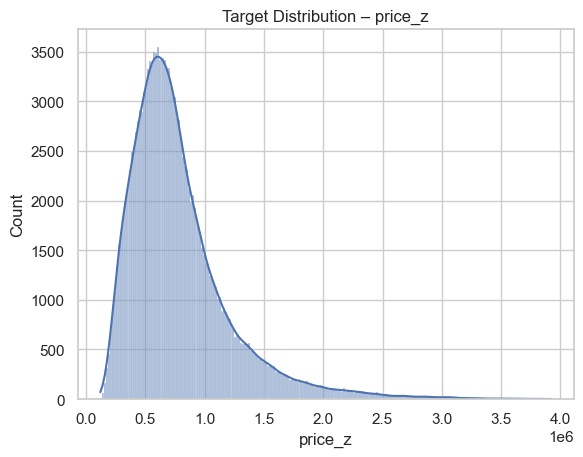

Skew : 1.841
Kurtosis: 5.199


In [ ]:
sns.histplot(train_df["price_z"], kde=True) # type: ignore
plt.title("Target Distribution – price_z")
plt.show()

print("Skew :", train_df["price_z"].skew().round(3)) # type: ignore
print("Kurtosis:", train_df["price_z"].kurtosis().round(3)) # type: ignore

The distribution of the target variable price_z is heavily right-skewed, with a long tail extending towards higher values. This violates the assumption of normality commonly required by many regression models and may also introduce heteroscedasticity. To stabilise variance and improve model performance, a log transformation of price_z will be applied, making the distribution more symmetrical and better suited for linear modelling techniques.

Now, we will examine the distribution of the numerical variables to assess whether applying a log transformation results in a more normal-like distribution.

<Axes: xlabel='price_z', ylabel='Count'>

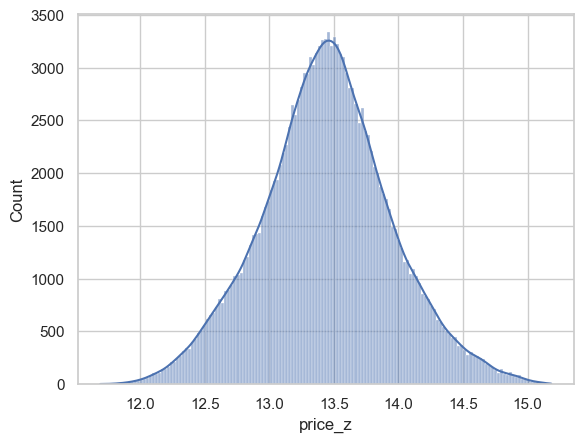

In [ ]:
# log transformation of the price variable
price_log = np.log1p(train_df["price_z"])
# and plot its histogram
sns.histplot(price_log, kde = True)

### Selection of Numerical Variables

Text(0.5, 1.01, 'Numeric Feature Distributions; train_df Dataset')

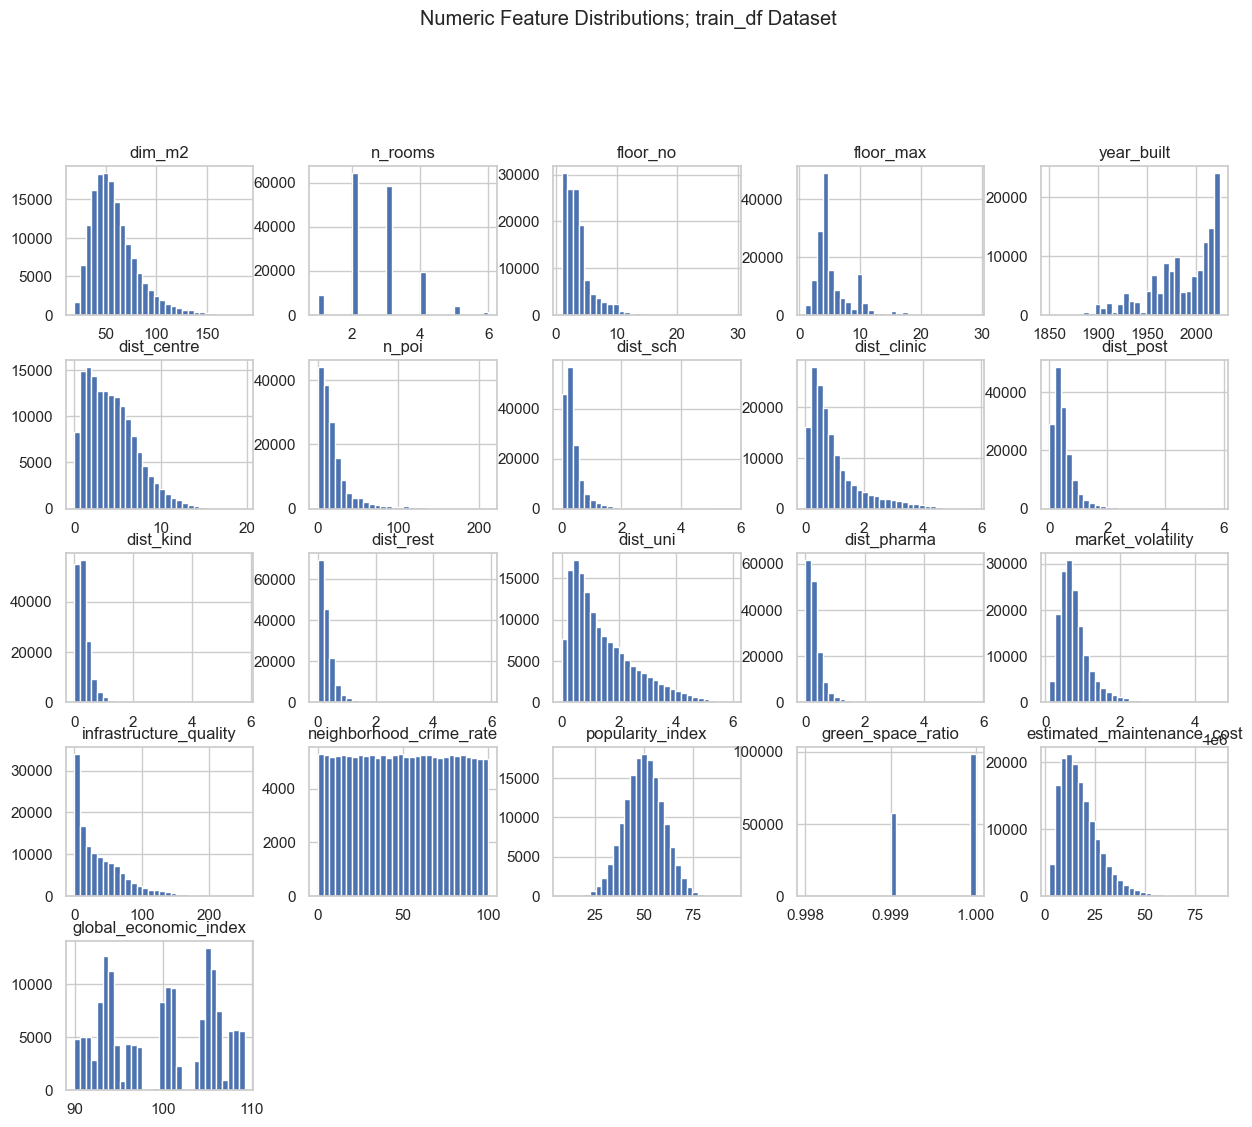

In [ ]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.drop("price_z")
train_df[numeric_cols].hist(bins=30, figsize=(15, 12))
plt.suptitle("Numeric Feature Distributions; train_df Dataset", y=1.01)

Most numerical features display right-skewed distributions, especially distance-related variables, market_volatility, and estimated_maintenance_cost, which may benefit from log transformation to normalise their scales. A few variables, such as year_built and popularity_index, exhibit more symmetric or uniform patterns.

However, it's worth noting that n_rooms and green_space_ratio show very limited distinct values, suggesting they may be better treated as categorical variables. Let’s proceed to convert those accordingly.

In [ ]:
train_df["n_rooms"] = train_df["n_rooms"].astype("category")
train_df["green_space_ratio"] = train_df["green_space_ratio"].astype("category")
test_df["n_rooms"] = test_df["n_rooms"].astype("category")
test_df["green_space_ratio"] = test_df["green_space_ratio"].astype("category")

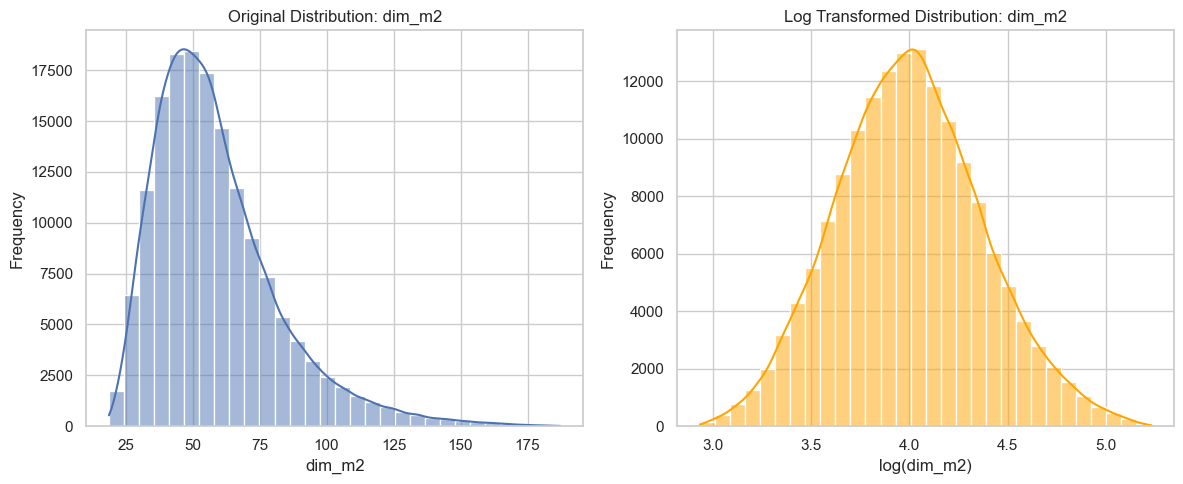

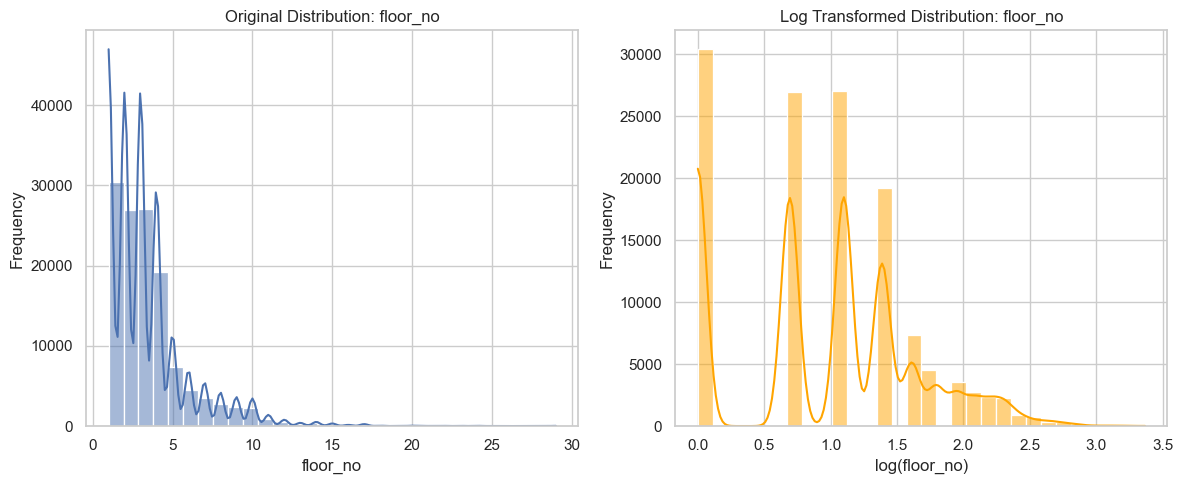

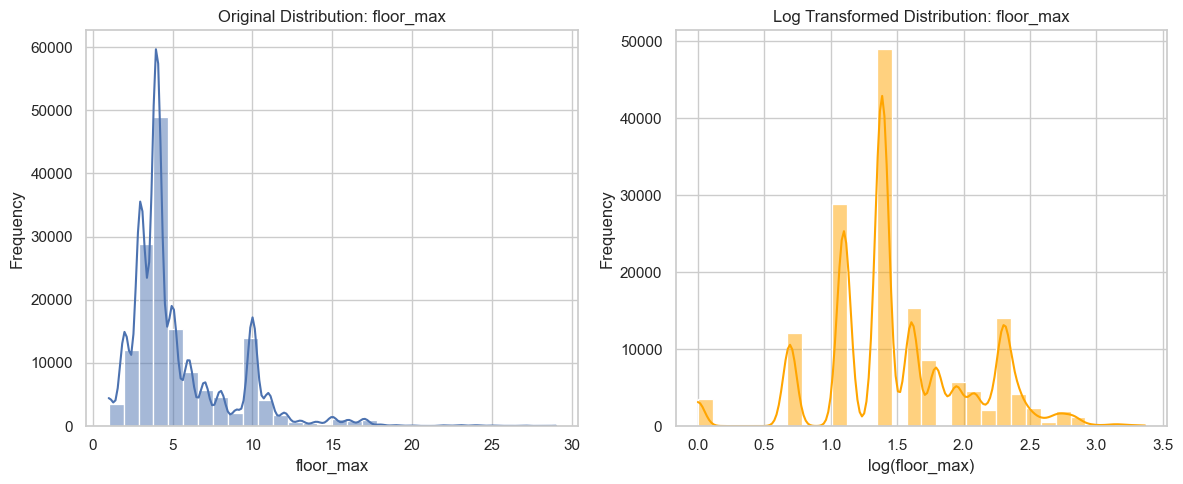

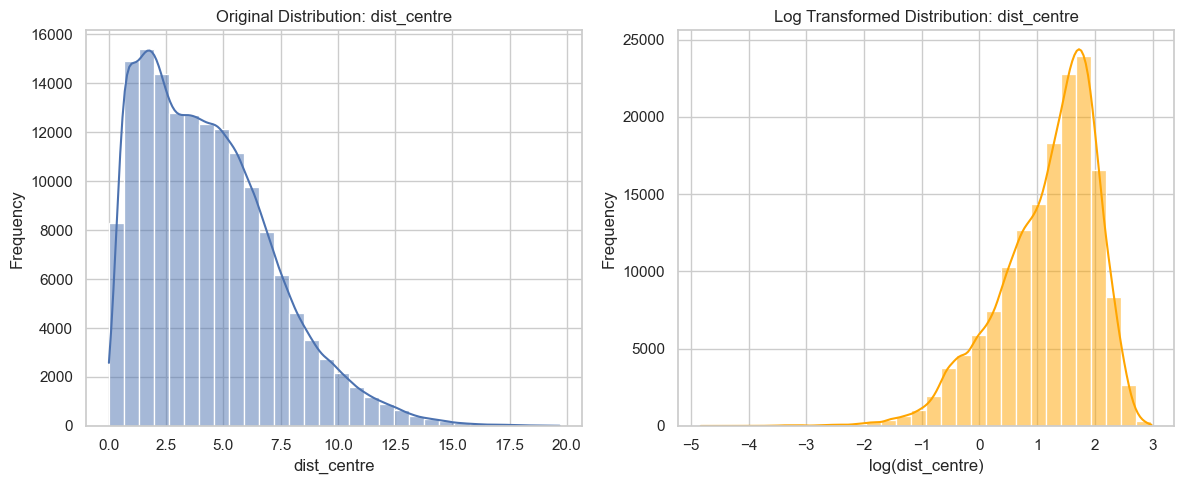

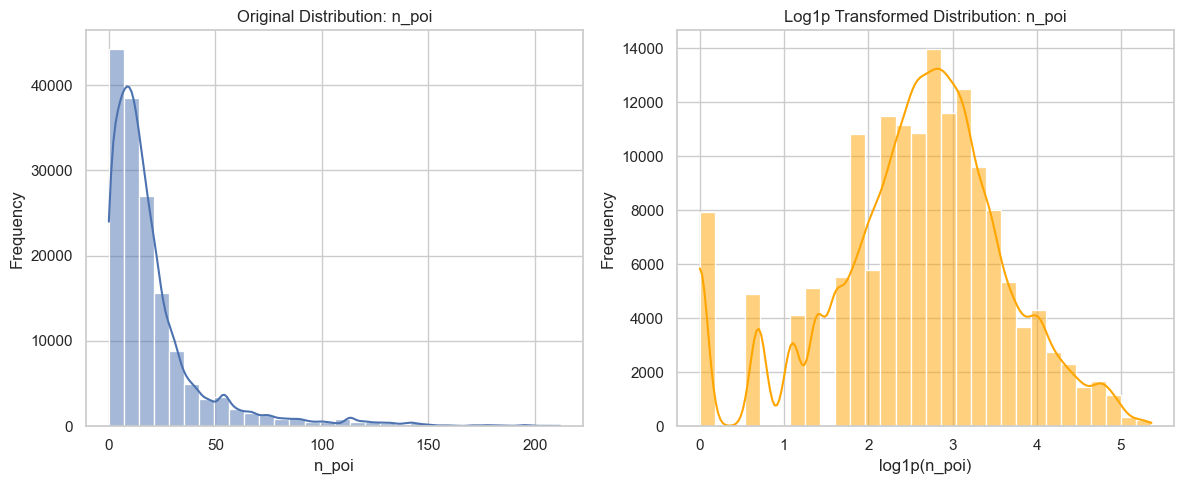

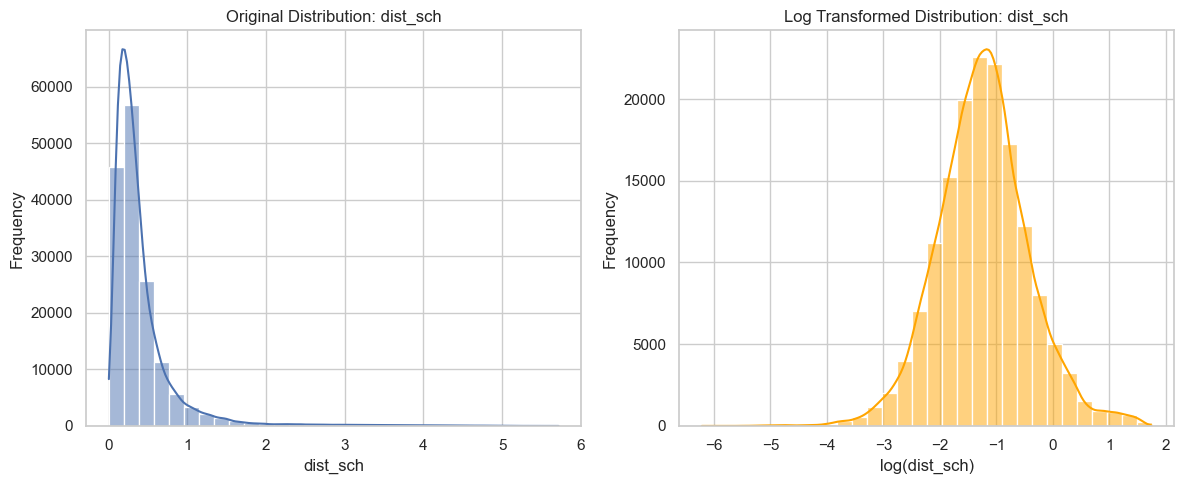

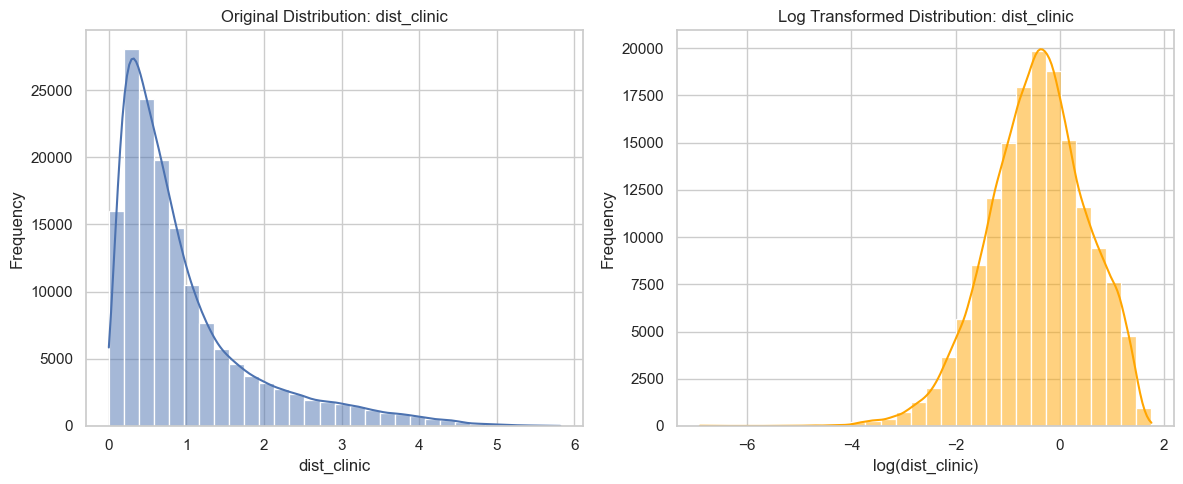

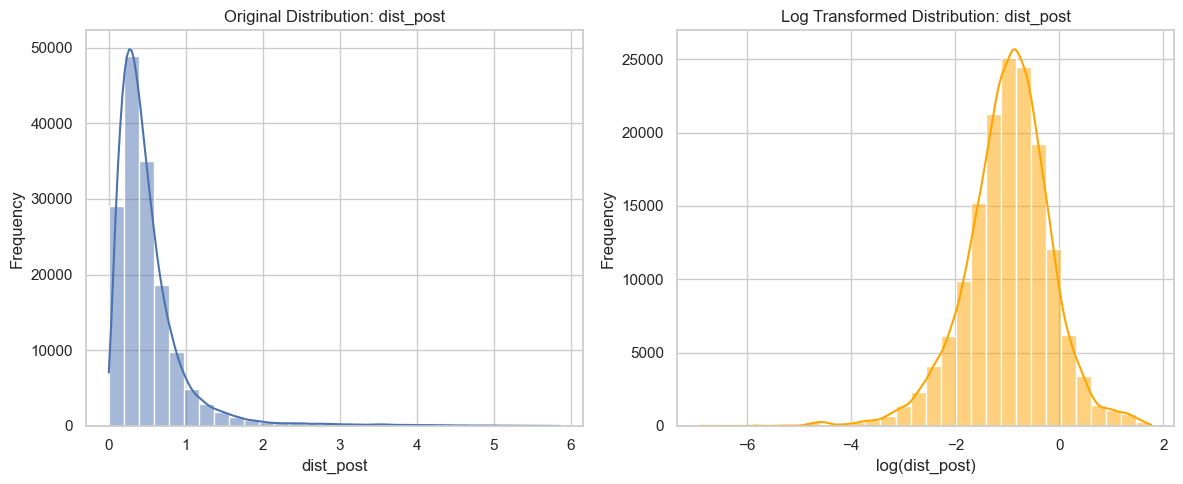

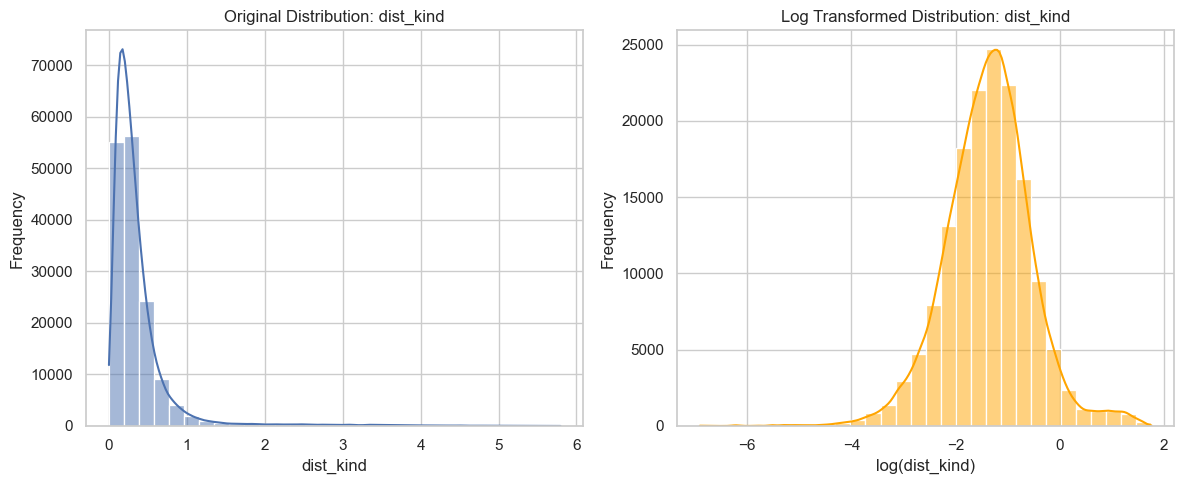

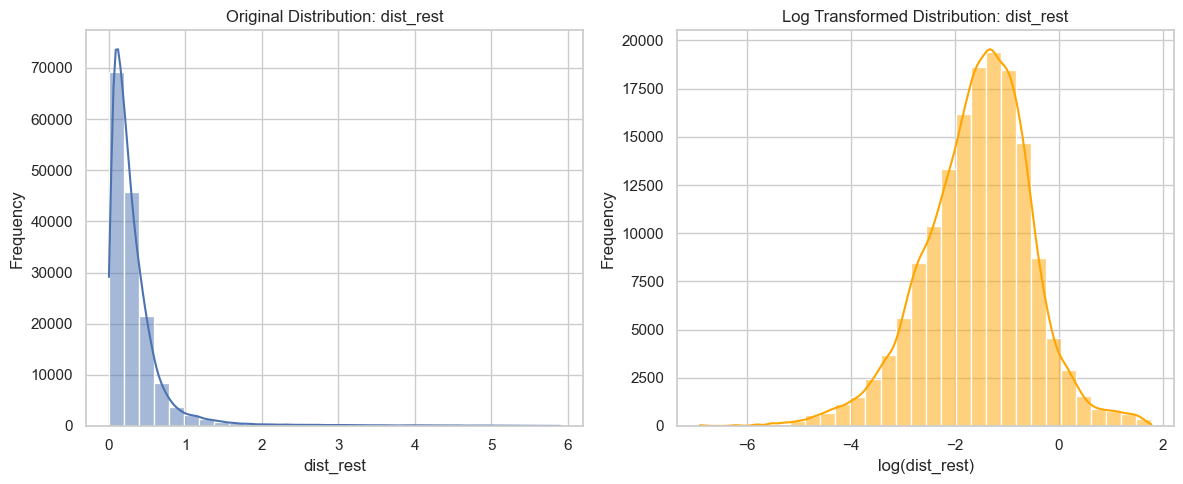

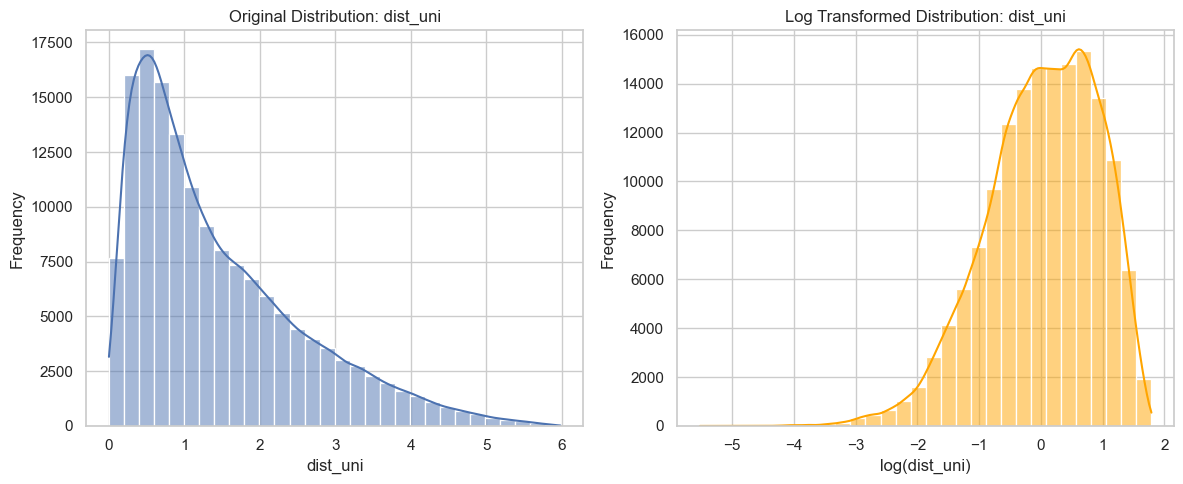

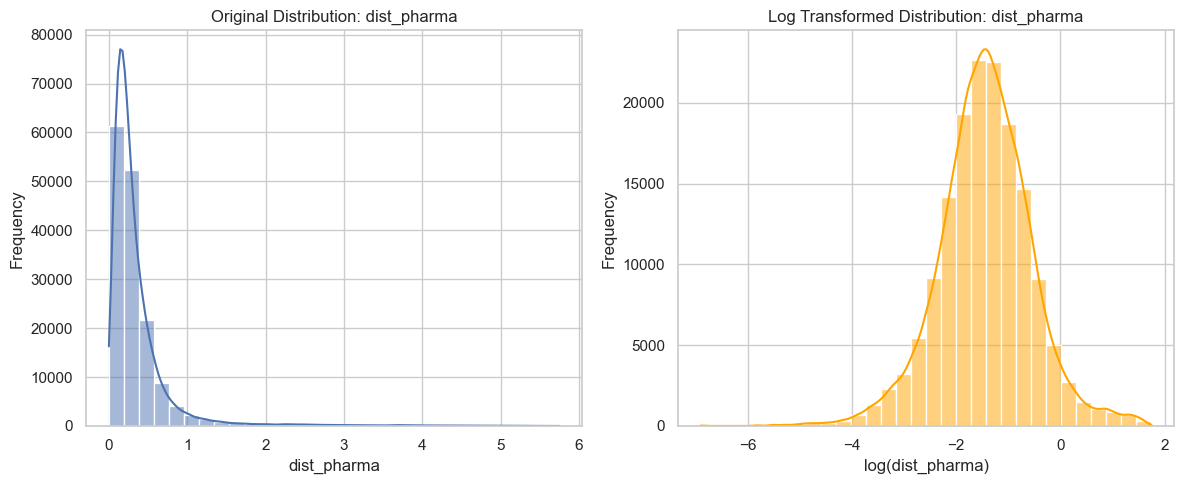

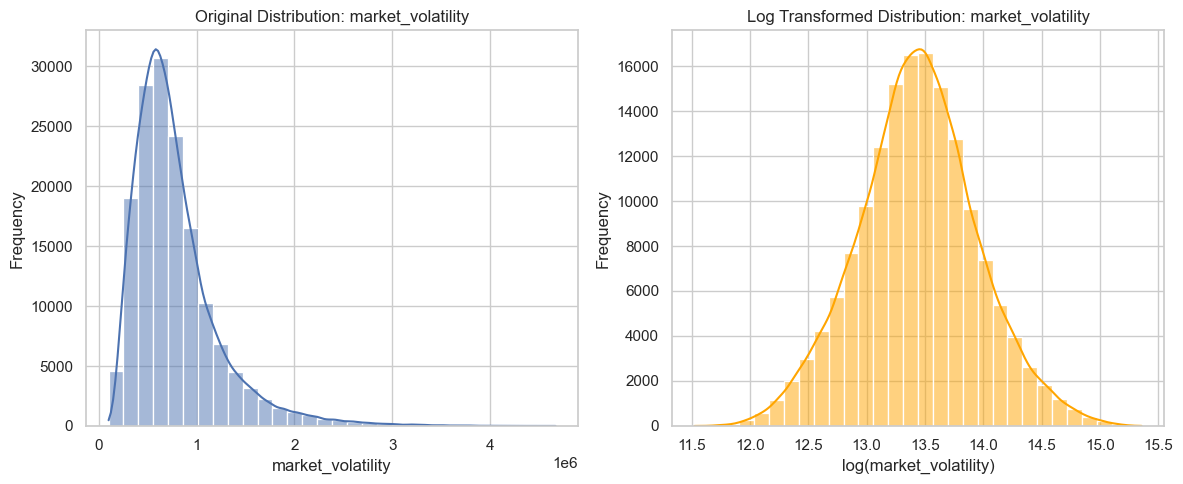

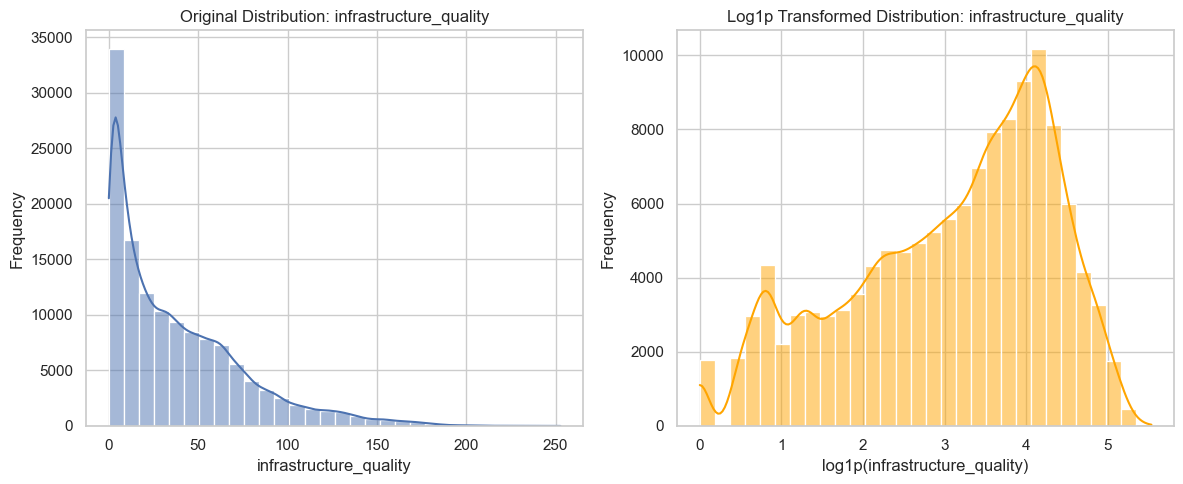

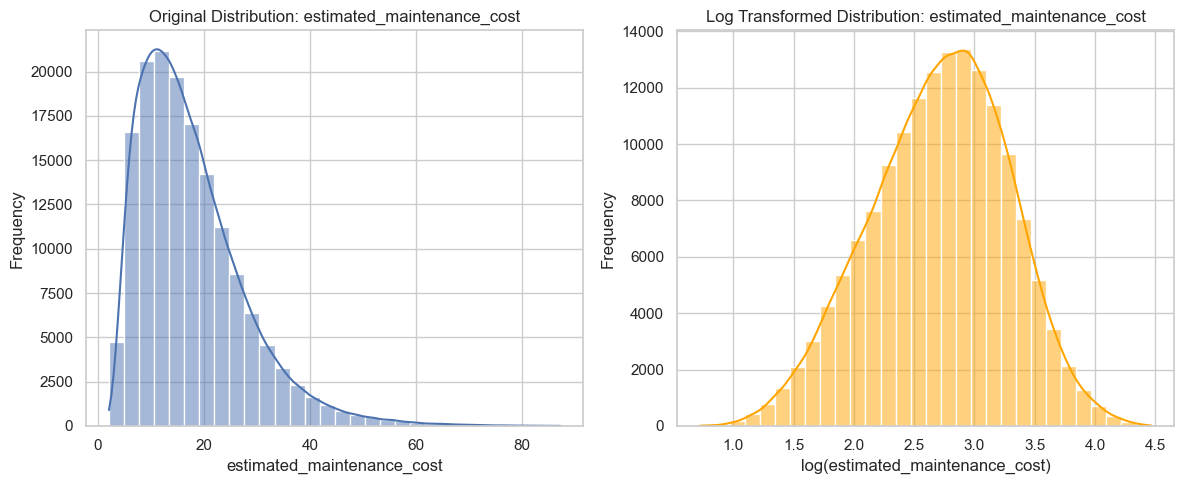

In [ ]:
# Select only numerical columns
numerical_cols = ['dim_m2','floor_no','floor_max','dist_centre',
                  'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'market_volatility', 'infrastructure_quality', 'estimated_maintenance_cost'
                  ]


sns.set_style("whitegrid")


for col in numerical_cols:
    plt.figure(figsize=(12, 5))

    # Original Distribution
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    sns.histplot(train_df[col], kde=True, bins=30) # type: ignore
    plt.title(f'Original Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Log-transformed Distribution
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot

    if (train_df[col] <= 0).any():
        print(f"Warning: Column '{col}' contains non-positive values. Using np.log1p(x).")
        sns.histplot(np.log1p(train_df[col]), kde=True, bins=30, color='orange')
        plt.title(f'Log1p Transformed Distribution: {col}')
        plt.xlabel(f'log1p({col})')
    else:
        sns.histplot(np.log(train_df[col]), kde=True, bins=30, color='orange')
        plt.title(f'Log Transformed Distribution: {col}')
        plt.xlabel(f'log({col})')


    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Applying log1p transformation for EDA purposes to the following columns:
- dim_m2
- floor_no
- floor_max
- dist_centre
- n_poi
- dist_sch
- dist_clinic
- dist_post
- dist_kind
- dist_rest
- dist_uni
- dist_pharma
- market_volatility
- infrastructure_quality
- estimated_maintenance_cost
- price_z

--- Correlations with 'price_z_log' (Sorted from Highest to Lowest) ---
market_volatility_log             0.974164
dim_m2_log                        0.541130
estimated_maintenance_cost_log    0.355280
year_built                        0.187254
dist_centre_log                   0.114304
n_poi_log                         0.100980
dist_sch_log                      0.040374
floor_max_log                     0.039398
dist_uni_log                      0.014227
dist_post_log                     0.009395
dist_pharma_log                   0.007421
global_economic_index             0.002490
popularity_index                  0.000824
floor_no_log                      0.000395
neighborhood_crime_rate     

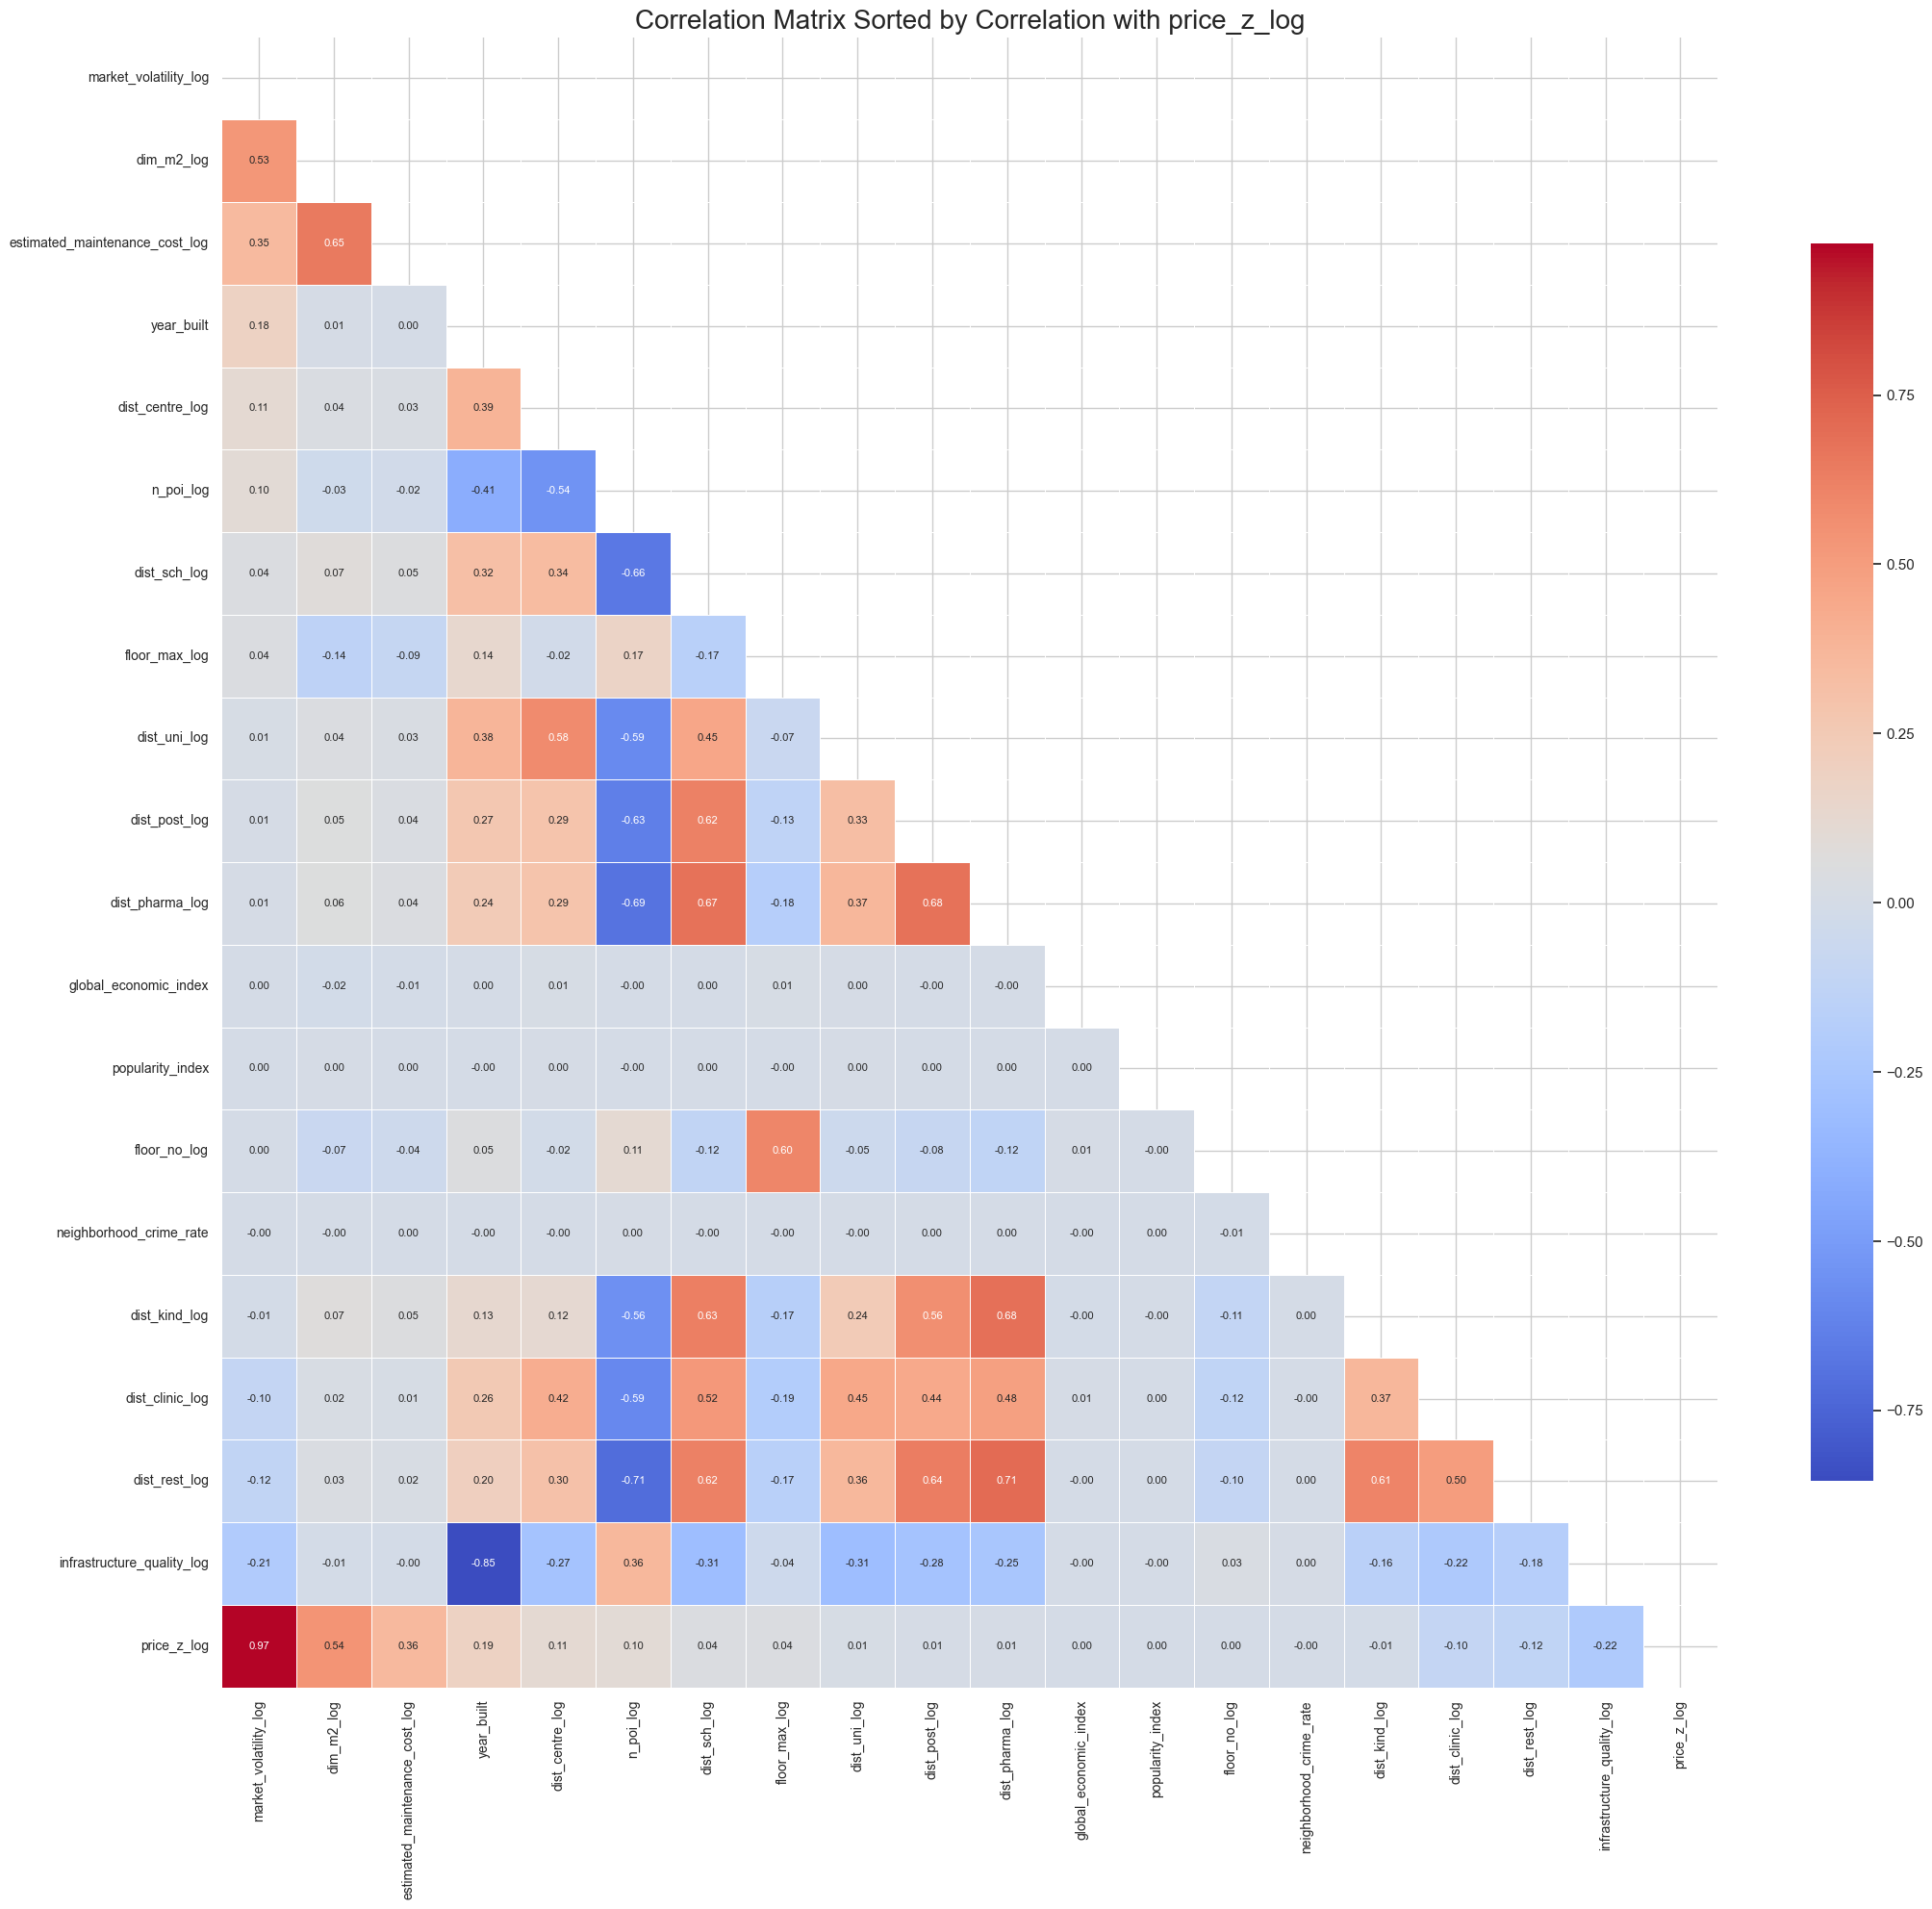

In [ ]:
applied_log_trans_numerical_cols = [
    'dim_m2', 'floor_no', 'floor_max', 'dist_centre',
    'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest',
    'dist_uni', 'dist_pharma', 'market_volatility', 'infrastructure_quality',
    'estimated_maintenance_cost', 'price_z' # price_z is now in this list
]

df_eda_transformed = train_df.copy()


print("Applying log1p transformation for EDA purposes to the following columns:")
for col in applied_log_trans_numerical_cols:
    if col in df_eda_transformed.columns:
        # Using np.log1p for robustness to zeros and to match previous practice
        df_eda_transformed[f'{col}_log'] = np.log1p(df_eda_transformed[col])
        print(f"- {col}")
    else:
        print(f"Warning: Column '{col}' specified for transformation not found in DataFrame.")

target_col_for_correlation = 'price_z_log'



cols_for_correlation_matrix = []
all_numerical_cols_original = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

for col in all_numerical_cols_original:
    if col == 'price_z' and target_col_for_correlation == 'price_z_log':
        continue

    if col in applied_log_trans_numerical_cols:
        if f'{col}_log' in df_eda_transformed.columns:
            cols_for_correlation_matrix.append(f'{col}_log')
        else: # Fallback to original if _log version not created
            cols_for_correlation_matrix.append(col)
    else:
        # Otherwise, use the original column
        cols_for_correlation_matrix.append(col)

# Add the target column explicitly if it's not already in the list
if target_col_for_correlation not in cols_for_correlation_matrix and target_col_for_correlation in df_eda_transformed.columns:
    cols_for_correlation_matrix.append(target_col_for_correlation)

cols_for_correlation_matrix = list(set(cols_for_correlation_matrix))
cols_for_correlation_matrix = [c for c in cols_for_correlation_matrix if c in df_eda_transformed.columns]


full_correlation_matrix = df_eda_transformed[cols_for_correlation_matrix].corr()

if target_col_for_correlation in full_correlation_matrix.columns:
    correlations_with_target = full_correlation_matrix[target_col_for_correlation].sort_values(ascending=False)
    correlations_with_target = correlations_with_target.drop(target_col_for_correlation, errors='ignore')

    print(f"\n--- Correlations with '{target_col_for_correlation}' (Sorted from Highest to Lowest) ---")
    print(correlations_with_target)

    ordered_cols_for_heatmap = correlations_with_target.index.tolist() + [target_col_for_correlation]
    ordered_cols_for_heatmap = [c for c in ordered_cols_for_heatmap if c in full_correlation_matrix.columns]

    sorted_correlation_matrix = full_correlation_matrix.loc[ordered_cols_for_heatmap, ordered_cols_for_heatmap]
    mask = np.triu(np.ones_like(sorted_correlation_matrix, dtype=bool))

    plt.figure(figsize=(22, 20)) # Adjust size for better readability
    sns.heatmap(sorted_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 8},
                mask=mask) # Apply the mask here
    plt.title(f'Correlation Matrix Sorted by Correlation with {target_col_for_correlation}', fontsize=20)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

else:
    print(f"\nError: Target variable '{target_col_for_correlation}' not found in the calculated correlation matrix.")


/var/folders/pk/lr4gvkwj30ngl_wv4qg43h5m0000gn/T/ipykernel_21167/3551478419.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations_sorted.index, y=target_correlations_sorted.values, palette='viridis')


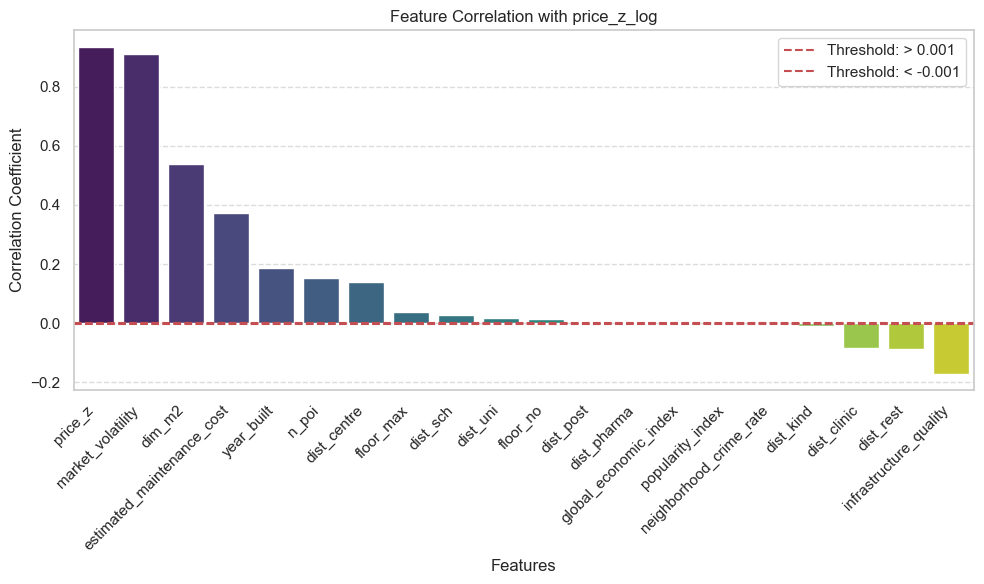

In [ ]:
train_corr = pd.read_csv('appartments_train.csv')

train_corr["n_rooms"] = train_corr["n_rooms"].astype("category")
train_corr["green_space_ratio"] = train_corr["green_space_ratio"].astype("category")


if 'price_z' in train_corr.columns:
    train_corr['price_z_log'] = np.log1p(train_corr['price_z'])
    target_variable_name = 'price_z_log'
else:
    print("Error: 'price_z' column not found in the DataFrame. Please check your data.")
    exit()

correlation_matrix = train_corr.corr(numeric_only=True)

if target_variable_name in correlation_matrix.columns:
    target_correlations = correlation_matrix[target_variable_name].drop(target_variable_name)
else:
    print(f"Error: Transformed target variable '{target_variable_name}' not found in correlation matrix. "
          "This shouldn't happen if 'price_z' was found and transformed successfully.")
    exit()

target_correlations_sorted = target_correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlations_sorted.index, y=target_correlations_sorted.values, palette='viridis')
plt.title(f'Feature Correlation with {target_variable_name}') # Use the name for the title
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

abs_correlation_threshold = 0.001 # A very small positive number, close to zero.

plt.axhline(y=abs_correlation_threshold, color='r', linestyle='--', label=f'Threshold: > {abs_correlation_threshold}')
plt.axhline(y=-abs_correlation_threshold, color='r', linestyle='--', label=f'Threshold: < -{abs_correlation_threshold}')
plt.legend()
plt.tight_layout()
plt.show()

Log transformation was applied to skewed numerical features, effectively reducing the skewness and making their distributions more symmetric. This improved the reliability of correlation analysis, helping to identify features with stronger linear relationships to the target. Based on this assessment, a refined set of numerical predictors was selected: market_volatility, dim_m2, estimated_maintenance_cost, n_poi, infrastructure_quality, dist_centre, dist_rest, dist_clinic, floor_max, dist_sch, and dist_uni.

### Selection of Categorical Variables

/var/folders/pk/lr4gvkwj30ngl_wv4qg43h5m0000gn/T/ipykernel_21167/3812936860.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_plot[col]): # type: ignore


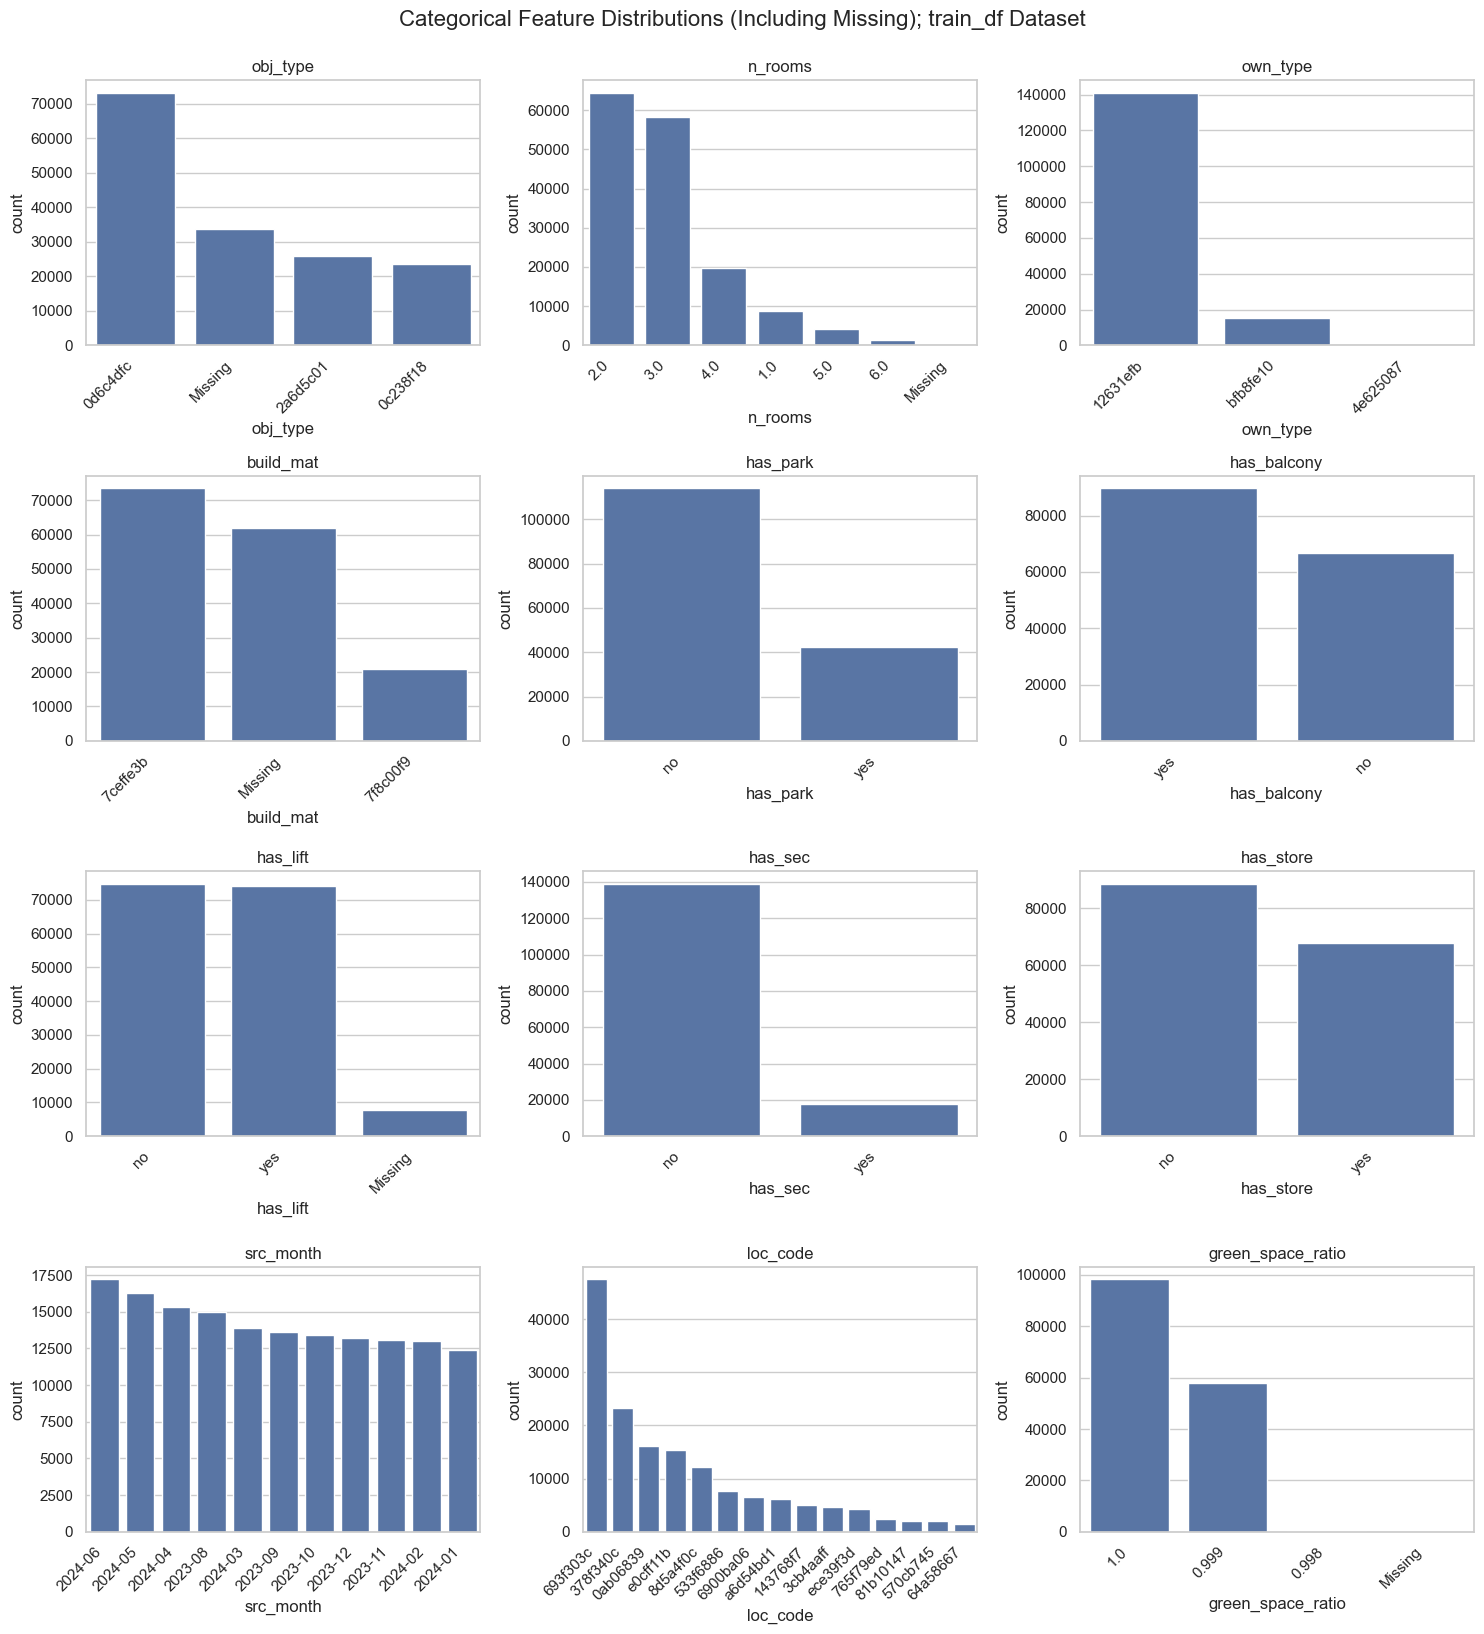

In [ ]:

df_plot = train_df.copy()


categorical_cols_analysis = df_plot.select_dtypes(include=["object", "category"]).columns


for col in categorical_cols_analysis:
    if pd.api.types.is_categorical_dtype(df_plot[col]): # type: ignore
        if "Missing" not in df_plot[col].cat.categories:
            df_plot[col] = df_plot[col].cat.add_categories("Missing")
    df_plot[col] = df_plot[col].fillna("Missing")


n_cols = 3
n_rows = math.ceil(len(categorical_cols_analysis) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))
sns.set(style="whitegrid")


for i, col in enumerate(categorical_cols_analysis, 1):
    plt.subplot(n_rows, n_cols, i)
    order = df_plot[col].value_counts().index
    sns.countplot(data=df_plot, x=col, order=order)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions (Including Missing); train_df Dataset", fontsize=16, y=1.02)
plt.show()


The categorical variables show varying levels of imbalance. Features such as has_sec, has_park, and has_lift are highly skewed towards one dominant class, which may influence model learning. n_rooms and green_space_ratio, although originally treated as numerical, clearly display discrete and limited value counts, justifying their conversion to categorical types. Additionally, some variables such as build_mat and obj_type contain a non-trivial amount of missing values, which will need to be addressed in preprocessing.

In [ ]:
def anova_for_categorical_vars(dataset, dep_var, cat_vars):
    results = []

    for var in cat_vars:
        model = smf.ols(f'{dep_var} ~ C({var})', data = dataset).fit()

        anova_table = anova_lm(model)

        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]

        results.append([var, f_statistic, p_value])

    anova_results_df = pd.DataFrame(results,
                                    columns = ['Variable', 'F-statistic', 'p-value'])

    anova_results_df = anova_results_df.sort_values(by = 'F-statistic',
                                                    ascending = False)
    return anova_results_df

In [ ]:
# and apply it to our data
categorical_anova = anova_for_categorical_vars(train_df,
                                                  'price_z',
                                                  categorical_cols_analysis)

# Display the result
print(categorical_anova)

             Variable  F-statistic        p-value
1             n_rooms  9153.386398   0.000000e+00
3           build_mat  7937.029873   0.000000e+00
0            obj_type  7481.079584   0.000000e+00
6            has_lift  5898.004374   0.000000e+00
8           has_store  4151.659578   0.000000e+00
10           loc_code  4016.960398   0.000000e+00
4            has_park  2928.606959   0.000000e+00
7             has_sec  2867.340981   0.000000e+00
2            own_type   890.181358   0.000000e+00
5         has_balcony   762.372912  2.071141e-167
11  green_space_ratio   442.085900  3.507697e-192
9           src_month   235.027819   0.000000e+00


To evaluate the influence of categorical features on the target variable, one-way ANOVA tests were performed. The results show that all tested variables have statistically significant differences in mean target values across their categories, with p-values effectively zero. Notably, n_rooms, build_mat, and obj_type show the highest F-statistics, suggesting they contribute strongly to explaining variance in the target. Other variables like has_lift, has_store, and loc_code also show substantial explanatory power, justifying their inclusion in the modelling pipeline.

In [ ]:
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def calculate_cramers_v_matrix(dataset, cat_vars):
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                    columns = cat_vars,
                                    index = cat_vars)

    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)):
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            cramers_v_value = cramers_v(contingency_table)

            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value
    return cramers_v_matrix

In [ ]:
categorical_cramers_v_matrix = calculate_cramers_v_matrix(train_df, categorical_cols_analysis)
categorical_cramers_v_matrix

,obj_type,n_rooms,own_type,build_mat,has_park,has_balcony,has_lift,has_sec,has_store,src_month,loc_code,green_space_ratio
obj_type,1.000000,0.097524,0.165459,0.593473,0.221865,0.333075,0.457648,0.195295,0.328788,0.035092,0.169184,0.204600
n_rooms,0.097524,1.000000,0.022556,0.109630,0.076598,0.129618,0.071898,0.030729,0.052203,0.020329,0.064094,0.049971
own_type,0.165459,0.022556,1.000000,0.369651,0.001719,0.051696,0.008290,0.077482,0.167178,0.012379,0.124645,0.011474
build_mat,0.593473,0.109630,0.369651,0.999969,0.131356,0.103008,0.087880,0.162168,0.265237,0.037667,0.204153,0.072587
has_park,0.221865,0.076598,0.001719,0.131356,0.999984,0.084294,0.124555,0.081409,0.036344,0.015533,0.186479,0.082941
has_balcony,0.333075,0.129618,0.051696,0.103008,0.084294,0.999987,0.098079,0.066237,0.093826,0.015545,0.117032,0.118699
has_lift,0.457648,0.071898,0.008290,0.087880,0.124555,0.098079,0.999987,0.139214,0.270927,0.040491,0.266377,0.102250
has_sec,0.195295,0.030729,0.077482,0.162168,0.081409,0.066237,0.139214,0.999968,0.114625,0.023942,0.171625,0.103031
has_store,0.328788,0.052203,0.167178,0.265237,0.036344,0.093826,0.270927,0.114625,0.999987,0.033404,0.169399,0.112360
src_month,0.035092,0.020329,0.012379,0.037667,0.015533,0.015545,0.040491,0.023942,0.033404,1.000000,0.023963,0.018366


<Axes: >

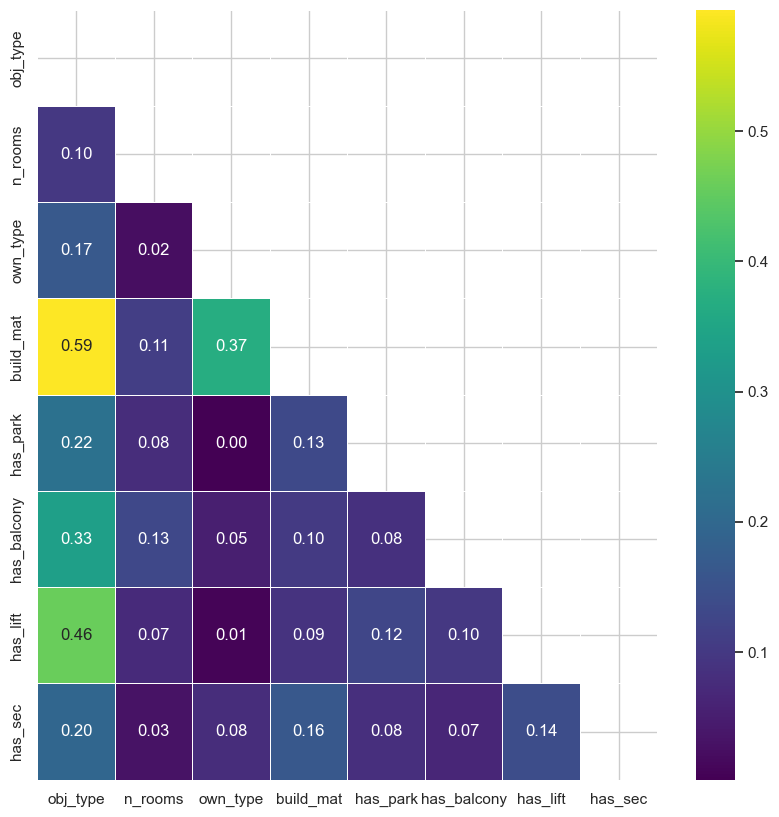

In [ ]:
mask = np.triu(np.ones_like(categorical_cramers_v_matrix, dtype = bool))


plt.figure(figsize=(10, 10))

sns.heatmap(categorical_cramers_v_matrix.iloc[:8, :8],
            annot = True,
            cmap = "viridis",
            fmt = ".2f",
            mask = mask[:8, :8],
            linewidths = 0.5)

To assess potential multicollinearity among categorical features, Cramér’s V was computed. Most feature pairs exhibit low to moderate association values, indicating limited redundancy.

## Data Preprocessing

### Finalised Feature Selection

In [ ]:
numerical_features = ['market_volatility','dim_m2','estimated_maintenance_cost','n_poi',
                    'infrastructure_quality','dist_centre','dist_rest','dist_clinic', 'floor_max','dist_sch','dist_uni']
categorical_features = ['obj_type', 'n_rooms', 'own_type', 'build_mat', 'has_park',
       'has_balcony', 'has_lift', 'has_sec', 'has_store',
       'loc_code', 'green_space_ratio']
target = 'price_z'

The final set of predictors consists of 11 numerical and 13 categorical features. Numerical features were selected based on earlier exploratory data analysis and statistical correlation with the target variable, ensuring strong linear relationships and minimal redundancy.

In [ ]:
for df in [train_df, test_df]:
    df['year_built_bin'] = pd.cut(df['year_built'], bins=[1900, 1950, 2000, 2025],
                                   labels=["pre-1950", "1950–2000", "post-2000"])
    df['year_built_bin'] = df['year_built_bin'].astype('category')
    df['year_built_bin'] = df['year_built_bin'].cat.add_categories('Missing').fillna('Missing')

    df['src_month_num'] = pd.to_datetime(df['src_month'], format='%Y-%m').dt.month
    df['src_month_bin'] = pd.cut(df['src_month_num'], bins=[0, 3, 6, 9, 12],
                                 labels=["Q1", "Q2", "Q3", "Q4"], include_lowest=True)
    df['src_month_bin'] = df['src_month_bin'].astype('category')

categorical_features.extend(['year_built_bin', 'src_month_bin'])

In [ ]:
train_df.drop(columns='year_built', inplace=True)
test_df.drop(columns='year_built', inplace=True)
train_df.drop(columns='src_month', inplace=True)
test_df.drop(columns='src_month', inplace=True)

For categorical features, two additional variables were derived through binning. year_built was grouped into three historical intervals to capture temporal construction trends and mitigate sparsity due to missing or irregular values. Similarly, src_month was binned into calendar quarters (Q1–Q4) to account for potential seasonal effects while avoiding overfitting from treating each month as a separate category. These engineered features help reduce noise and improve model generalisability.

### Split Train/Validation on Internal Training Set

In [ ]:
X = train_df[numerical_features + categorical_features].copy()
y = np.log1p(train_df[target])  # log-transform target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

,market_volatility,dim_m2,estimated_maintenance_cost,n_poi,infrastructure_quality,dist_centre,dist_rest,dist_clinic,floor_max,dist_sch,...,build_mat,has_park,has_balcony,has_lift,has_sec,has_store,loc_code,green_space_ratio,year_built_bin,src_month_bin
96871,1343939.66,66.99,19.23,16.0,NaN,5.507,NaN,0.180,10.0,0.565,...,NaN,no,yes,yes,yes,no,693f303c,0.999,Missing,Q1
85950,1029030.60,54.58,14.26,13.0,0.00,3.971,0.096,0.939,3.0,0.168,...,7ceffe3b,yes,yes,yes,no,no,693f303c,1.000,post-2000,Q2
117011,421432.28,65.52,7.32,21.0,48.85,3.908,0.289,1.223,4.0,0.205,...,7f8c00f9,no,yes,no,no,yes,3cb4aaff,1.000,1950–2000,Q4
3997,342176.37,57.81,22.96,8.0,72.22,4.831,0.448,0.563,11.0,0.230,...,7f8c00f9,no,no,yes,no,no,8d5a4f0c,1.000,1950–2000,Q4
66009,430504.37,36.24,17.91,48.0,63.99,1.077,0.192,0.317,4.0,0.079,...,7ceffe3b,yes,yes,no,no,yes,0ab06839,1.000,1950–2000,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1629463.05,77.72,30.78,33.0,104.22,1.724,0.053,0.064,4.0,0.233,...,7ceffe3b,yes,no,no,yes,yes,693f303c,1.000,pre-1950,Q4
103694,2654069.92,100.04,40.65,25.0,0.69,2.724,0.045,0.367,5.0,0.423,...,7ceffe3b,no,yes,yes,yes,no,693f303c,1.000,post-2000,Q1
131932,704519.08,52.31,7.64,28.0,53.31,8.381,0.074,0.489,10.0,0.273,...,NaN,no,yes,no,no,yes,693f303c,0.999,1950–2000,Q3
146867,2024181.81,99.74,37.17,3.0,2.62,5.582,0.386,0.464,6.0,0.442,...,7ceffe3b,no,no,yes,yes,no,693f303c,0.999,post-2000,Q2


### Imputation of Missing Values

In [ ]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer.fit(X_train[numerical_features])
cat_imputer.fit(X_train[categorical_features])

X_train[numerical_features] = num_imputer.transform(X_train[numerical_features])
X_val[numerical_features] = num_imputer.transform(X_val[numerical_features])
test_df[numerical_features] = num_imputer.transform(test_df[numerical_features])

X_train[categorical_features] = cat_imputer.transform(X_train[categorical_features])
X_val[categorical_features] = cat_imputer.transform(X_val[categorical_features])
test_df[categorical_features] = cat_imputer.transform(test_df[categorical_features])

To handle missing data, separate imputation strategies were applied based on variable type. Numerical features were imputed using the median, a robust measure that reduces the impact of outliers on central tendency. Categorical features were imputed with the most frequent category, preserving the mode of each variable. Importantly, the imputers were fit only on the training set to prevent data leakage, and the learned parameters were then applied to the validation and test sets. This ensures consistency and maintains the integrity of the modelling pipeline.

### Logarithmic Transformation

In [ ]:
log_transform_cols = numerical_features.copy()
for col in log_transform_cols:
    X_train[f'log_{col}'] = np.log1p(X_train[col])
    X_val[f'log_{col}'] = np.log1p(X_val[col])
    test_df[f'log_{col}'] = np.log1p(test_df[col])
    X_train.drop(columns=col, inplace=True)
    X_val.drop(columns=col, inplace=True)
    test_df.drop(columns=col, inplace=True)

To address skewness and improve linear model assumptions, all selected numerical features were log-transformed using the log1p function, which handles zero values safely. This transformation compresses large values and expands small ones, helping to stabilise variance and linearise relationships with the target. Each transformed feature was prefixed with log_, and the original untransformed columns were removed to avoid redundancy and multicollinearity. This step was applied consistently across the training, validation, and test sets.

### Encoding on Categorical Variables

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_features])

X_train_cat = pd.DataFrame(encoder.transform(X_train[categorical_features]), # type: ignore
                           columns=encoder.get_feature_names_out(categorical_features), index=X_train.index) # type: ignore
X_val_cat = pd.DataFrame(encoder.transform(X_val[categorical_features]), # type: ignore
                         columns=encoder.get_feature_names_out(categorical_features), index=X_val.index) # type: ignore
X_test_cat = pd.DataFrame(encoder.transform(test_df[categorical_features]), # type: ignore
                          columns=encoder.get_feature_names_out(categorical_features), index=test_df.index)

X_train.drop(columns=categorical_features, inplace=True)
X_val.drop(columns=categorical_features, inplace=True)
test_df.drop(columns=categorical_features, inplace=True)

X_train_final = pd.concat([X_train, X_train_cat], axis=1)
X_val_final = pd.concat([X_val, X_val_cat], axis=1)
# X_test_final = pd.concat([test_df[X_train_final.columns.difference(X_train_final.columns)], X_test_cat], axis=1)

# Configuration for Test Dataset
X_test_num = test_df[X_train_final.columns.intersection(test_df.columns)]  # only numeric/log cols used in training
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)
X_test_final = X_test_final[X_train_final.columns]  # reorder and align columns exactly


## Modelling with Hyperparameter Tuning

To ensure consistent and fair model evaluation, a 5-fold cross-validation strategy was defined using KFold with shuffling and a fixed random seed for reproducibility. A logarithmic range of regularisation strengths (alphas) was prepared for models that require tuning, such as Ridge, Lasso, and ElasticNet. The print_metrics function was implemented to standardise performance reporting across models. It reverses the log transformation of the target variable (price_z) using expm1 before calculating performance metrics: RMSE, MAE, and R². The results are printed for transparency and stored in metric_log for later comparison.

### Initial Set Up

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(-3, 4, 50)

models = {}
metric_log = []


def print_metrics(name, model, X, y):
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    metric_log.append((name, rmse, mae, r2))
    return rmse


Several models were trained and compared, including Ordinary Least Squares (OLS), Ridge, Lasso, ElasticNet, and K-Nearest Neighbours (KNN). After extensive evaluation using the validation set, XGBoost was selected as the final model due to its superior performance, achieving the lowest Root Mean Squared Error (RMSE). This indicates that XGBoost provided the best predictive accuracy among the tested algorithms for this particular regression task.

In [ ]:
from tabulate import tabulate

# Create table from metric_log
metrics_table = pd.DataFrame(metric_log, columns=["Model", "RMSE", "MAE", "R2"])
metrics_table.set_index("Model", inplace=True)

# Print table in nice format
print(tabulate(metrics_table, headers='keys', tablefmt='fancy_grid', floatfmt=".3f")) # type: ignore

╒═════════════════════╤════════════╤════════════╤═══════╕
│ Model               │       RMSE │        MAE │    R2 │
╞═════════════════════╪════════════╪════════════╪═══════╡
│ Linear              │  96661.140 │  69894.471 │ 0.951 │
├─────────────────────┼────────────┼────────────┼───────┤
│ Ridge               │  96634.278 │  69880.721 │ 0.951 │
├─────────────────────┼────────────┼────────────┼───────┤
│ Lasso               │  96851.456 │  70230.531 │ 0.951 │
├─────────────────────┼────────────┼────────────┼───────┤
│ ElasticNet          │ 298921.540 │ 186211.389 │ 0.530 │
├─────────────────────┼────────────┼────────────┼───────┤
│ KNN                 │ 220261.851 │ 146305.666 │ 0.745 │
├─────────────────────┼────────────┼────────────┼───────┤
│ XGBoost             │  95670.119 │  68788.042 │ 0.952 │
├─────────────────────┼────────────┼────────────┼───────┤
│ XGBoost (retrained) │  86244.736 │  63061.671 │ 0.960 │
╘═════════════════════╧════════════╧════════════╧═══════╛


### Additional Model Implementation XGBoost (Tree Based Model)

In [ ]:
# XGBOOST
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Set up CV grid
xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(
    xgb,
    param_grid=xgb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid
xgb_grid.fit(X_train_final, y_train)

# Get best model
xgb_best = xgb_grid.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
models['XGBoost'] = (xgb_best, print_metrics("XGBoost", xgb_best, X_val_final, y_val))

XGBoost → RMSE: 95670.12 | MAE: 68788.04 | R²: 0.9519


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Choosing Best Model

In [ ]:
best_model_name, (best_model, best_rmse) = min(models.items(), key=lambda x: x[1][1])
print(f"\nBest model: {best_model_name} with RMSE: {best_rmse:.2f}")


Best model: XGBoost with RMSE: 95670.12


In [ ]:
X_all = pd.concat([X_train_final, X_val_final], axis=0)
y_all = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_all, y_all)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
train_val_rmse = print_metrics(f"{best_model_name} (retrained)", best_model, X_all, y_all)

XGBoost (retrained) → RMSE: 86244.74 | MAE: 63061.67 | R²: 0.9598


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


After selecting the best-performing model based on validation RMSE, the training and validation sets were combined to form a larger dataset (X_all, y_all). This allows the final model to be retrained on the full available data before making predictions on the unseen test set, thereby maximising its learning capacity. Once retrained, the model’s performance was re-evaluated on this combined data using the same print_metrics function to ensure consistency and confirm no degradation in predictive accuracy.

## Generate Prediction

In [ ]:
test_preds_log = best_model.predict(X_test_final)
test_preds_real = np.expm1(test_preds_log)


In [ ]:
submission = pd.DataFrame({
    'id': test_ids,
    'predicted_price': test_preds_real
})
submission.to_csv("apartments_predictions.csv", index=False)
print("\nSaved: apartments_predictions.csv")


Saved: apartments_predictions.csv


## Post Diagnosis on Result

In [ ]:

feature_names = X_test_final.columns

importances = best_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Show top 20
print(importance_df.head(20))

                     feature  importance
0      log_market_volatility    0.238309
43         loc_code_693f303c    0.137458
55  year_built_bin_post-2000    0.098481
14               n_rooms_1.0    0.096971
37         loc_code_378f340c    0.054069
48         loc_code_e0cff11b    0.042536
35         loc_code_0ab06839    0.040762
15               n_rooms_2.0    0.039451
44         loc_code_765f79ed    0.034752
46         loc_code_8d5a4f0c    0.026657
16               n_rooms_3.0    0.025267
12         obj_type_0d6c4dfc    0.022372
45         loc_code_81b10147    0.021042
1                 log_dim_m2    0.016925
18               n_rooms_5.0    0.012153
17               n_rooms_4.0    0.012146
39         loc_code_533f6886    0.010523
42         loc_code_6900ba06    0.008697
49         loc_code_ece39f3d    0.007086
13         obj_type_2a6d5c01    0.007035


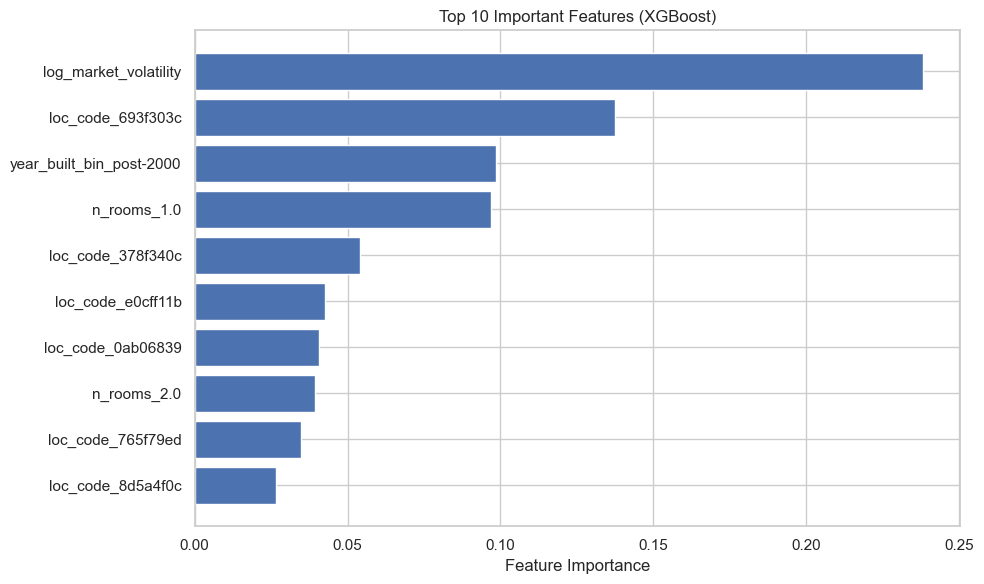

In [ ]:
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features (XGBoost)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

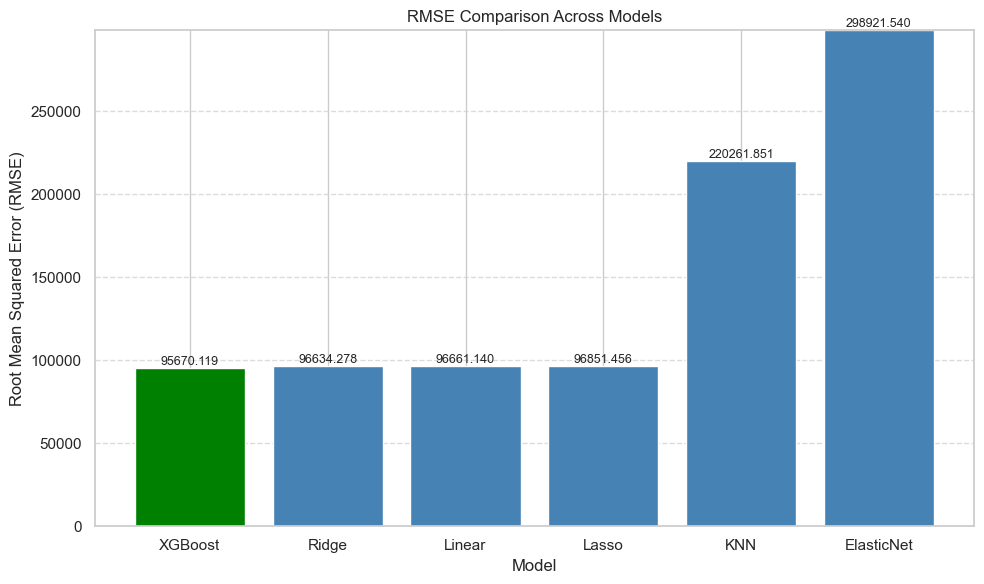

In [ ]:
rmse_data = {
    'Model': ['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'KNN', 'XGBoost'],
    'RMSE':  [96661.140, 96634.278, 96851.456, 298921.540, 220261.851, 95670.119]
}

rmse_df = pd.DataFrame(rmse_data)

# Sort by RMSE ascending (lowest is better)
rmse_df.sort_values(by='RMSE', inplace=True)

# Identify the best (lowest) RMSE
min_index = rmse_df['RMSE'].idxmin()

# Plot
plt.figure(figsize=(10, 6))
colors = ['green' if i == min_index else 'steelblue' for i in rmse_df.index]
bars = plt.bar(rmse_df['Model'], rmse_df['RMSE'], color=colors)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f"{height:.3f}",
             ha='center', va='bottom', fontsize=9)

# Formatting
plt.title('RMSE Comparison Across Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Model')
plt.ylim(0, rmse_df['RMSE'].max() + 0.02)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
X_train_final

,log_market_volatility,log_dim_m2,log_estimated_maintenance_cost,log_n_poi,log_infrastructure_quality,log_dist_centre,log_dist_rest,log_dist_clinic,log_floor_max,log_dist_sch,...,green_space_ratio_0.999,green_space_ratio_1.0,year_built_bin_1950–2000,year_built_bin_Missing,year_built_bin_post-2000,year_built_bin_pre-1950,src_month_bin_Q1,src_month_bin_Q2,src_month_bin_Q3,src_month_bin_Q4
96871,14.111117,4.219361,3.007167,2.833213,3.356549,1.872879,0.203757,0.165514,2.397895,0.447886,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
85950,13.844129,4.017823,2.725235,2.639057,0.000000,1.603621,0.091667,0.662172,1.386294,0.155293,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
117011,12.951417,4.197503,2.118662,3.091042,3.909018,1.590867,0.253867,0.798858,1.609438,0.186480,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3997,12.743085,4.074312,3.176386,2.197225,4.293469,1.763189,0.370183,0.446607,2.484907,0.207014,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66009,12.972715,3.617383,2.939691,3.891820,4.174233,0.730925,0.175633,0.275356,1.609438,0.076035,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,14.303762,4.365897,3.458837,3.526361,4.656053,1.002101,0.051643,0.062035,1.609438,0.209450,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
103694,14.791605,4.615516,3.729301,3.258097,0.524729,1.314798,0.044017,0.312619,1.791759,0.352767,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
131932,13.465272,3.976124,2.156403,3.367296,3.994708,2.238686,0.071390,0.398105,2.397895,0.241376,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
146867,14.520677,4.612543,3.642050,1.386294,1.286474,1.884339,0.326422,0.381172,1.945910,0.366031,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
